In [1]:
import pandas as pd
import hvplot.pandas
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
ICE_USDCNY_1D = Path("Resources/ICE_USDCNY_1D.csv")

In [27]:
usdcny_1D = pd.read_csv(
    ICE_USDCNY_1D,
    index_col="time",
    parse_dates=True,
)
usdcny_1D = usdcny_1D.dropna()
print('Shape of data', usdcny_1D.shape)
usdcny_1D.head()

Shape of data (10919, 5)


,open,high,low,close,Volume
time,,,,,
1981-01-02,1.5341,1.5341,1.5341,1.5341,0
1981-01-05,1.5418,1.5418,1.5418,1.5418,0
1981-01-06,1.5264,1.5264,1.5264,1.5264,0
1981-01-07,1.5264,1.5264,1.5264,1.5264,0
1981-01-08,1.5264,1.5264,1.5264,1.5264,0


In [28]:
usdcny_1D = usdcny_1D.rename_axis("Date")
usdcny_1D.head()

,open,high,low,close,Volume
Date,,,,,
1981-01-02,1.5341,1.5341,1.5341,1.5341,0
1981-01-05,1.5418,1.5418,1.5418,1.5418,0
1981-01-06,1.5264,1.5264,1.5264,1.5264,0
1981-01-07,1.5264,1.5264,1.5264,1.5264,0
1981-01-08,1.5264,1.5264,1.5264,1.5264,0


In [29]:
usdcny_1D = usdcny_1D[["close"]]

usdcny_1D.tail()

,close
Date,
2024-03-08,7.1850
2024-03-11,7.1815
2024-03-12,7.1795
2024-03-13,7.1856
2024-03-14,7.1927


<Axes: xlabel='Date'>

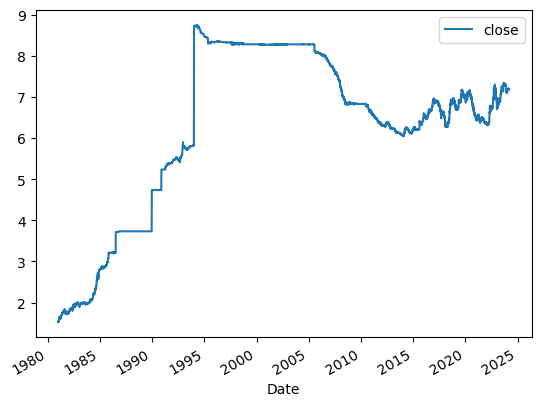

In [30]:
usdcny_1D.plot()

In [31]:
# Post-currency devaluation August 2015

start_date = '2015-08-01'
end_date = '2024-03-14'

# Boolean indexing to select rows within the specified date range
usdcny_post2015 = usdcny_1D[(usdcny_1D.index >= start_date) & (usdcny_1D.index <= end_date)]
usdcny_post2015

,close
Date,
2015-08-03,6.2087
2015-08-04,6.2085
2015-08-05,6.2095
2015-08-06,6.2095
2015-08-07,6.2085
...,...
2024-03-08,7.1850
2024-03-11,7.1815
2024-03-12,7.1795


<Axes: xlabel='Date'>

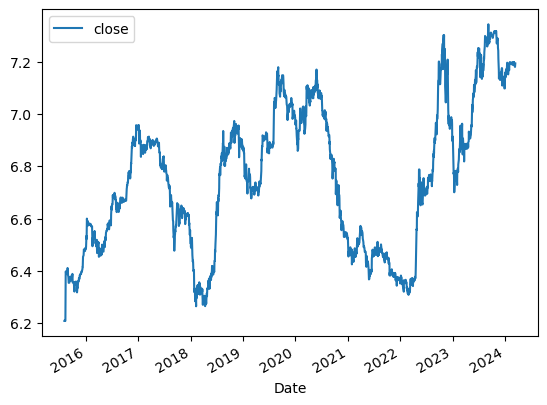

In [32]:
usdcny_post2015.plot()

## Check for Stationarity

In [9]:
# Function that checks for stationarity
from statsmodels.tsa.stattools import adfuller
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [10]:
check_stationarity(usdcny_post2015)

The series is NOT stationary


## Figure out Order for ARIMA Model

In [11]:
from pmdarima.arima import auto_arima

stepwise_fit = auto_arima(
    usdcny_post2015, 
    trace=True,
    suppress_warnings=True, 
    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11689.942, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11693.337, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11691.411, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11691.412, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11693.995, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11689.412, Time=0.54 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.369 seconds


In [12]:
from statsmodels.tsa.arima.model import ARIMA

In [13]:
# Assigning frequency for the model to recognize how to plot dates
usdcny_post2015.index = pd.DatetimeIndex(usdcny_post2015.index).to_period('D')

In [33]:
usdcny_post2015 = usdcny_post2015.asfreq('d')

In [34]:
usdcny_post2015.index

DatetimeIndex(['2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06',
               '2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10',
               '2015-08-11', '2015-08-12',
               ...
               '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08',
               '2024-03-09', '2024-03-10', '2024-03-11', '2024-03-12',
               '2024-03-13', '2024-03-14'],
              dtype='datetime64[ns]', name='Date', length=3147, freq='D')

## Split Data into Training and Testing

In [14]:
print(usdcny_post2015.shape)
train = usdcny_post2015.iloc[:-30]
test = usdcny_post2015.iloc[-30:]
print(train.shape, test.shape)

(2248, 1)
(2218, 1) (30, 1)


## Train the Model

In [15]:
model = ARIMA(train, order=(0,1,0))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 2218
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5756.139
Date:                Sat, 23 Mar 2024   AIC                         -11510.279
Time:                        21:50:06   BIC                         -11504.575
Sample:                    08-03-2015   HQIC                        -11508.195
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   5.26e-06     61.793      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              2228.26
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Make Predictions on Test Dataset

In [16]:
# Note, Ran into a case where the prediction would constantly return a straight line
'''
This is due to the fact that each prediction will be predicted from a prediction value.
'''

'\nThis is due to the fact that each prediction will be predicted from a prediction value.\n'

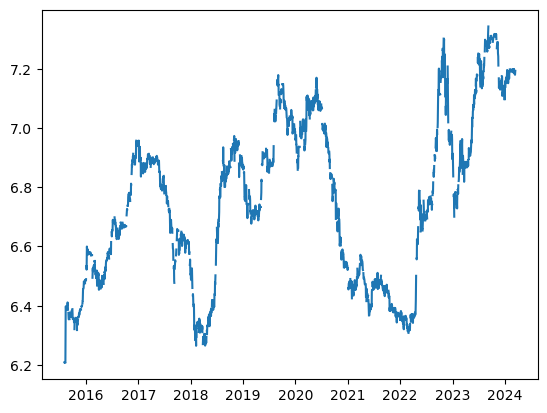

In [35]:
plt.plot(usdcny_post2015.index, usdcny_post2015.values)
plt.show()

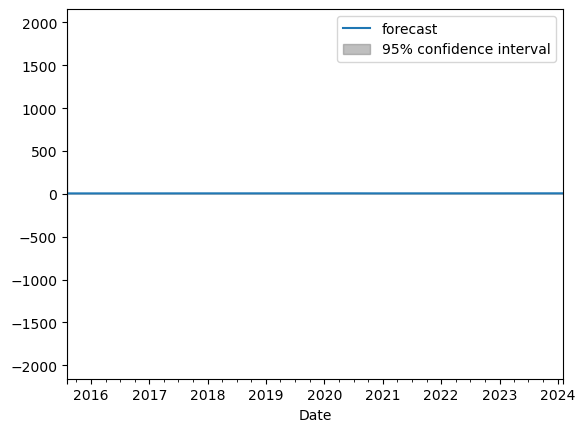

In [36]:
from statsmodels.graphics.tsaplots import plot_predict

plot_predict(model)
plt.show()

In [16]:
start = len(train)
end = len(train)+len(test) - 1
pred = model.predict(start=start, end=end, typ='levels')
pred.index=usdcny_post2015.index[start:end+1]
print(pred)

Date
2024-02-02    7.1794
2024-02-05    7.1794
2024-02-06    7.1794
2024-02-07    7.1794
2024-02-08    7.1794
2024-02-09    7.1794
2024-02-12    7.1794
2024-02-13    7.1794
2024-02-14    7.1794
2024-02-15    7.1794
2024-02-16    7.1794
2024-02-19    7.1794
2024-02-20    7.1794
2024-02-21    7.1794
2024-02-22    7.1794
2024-02-23    7.1794
2024-02-26    7.1794
2024-02-27    7.1794
2024-02-28    7.1794
2024-02-29    7.1794
2024-03-01    7.1794
2024-03-04    7.1794
2024-03-05    7.1794
2024-03-06    7.1794
2024-03-07    7.1794
2024-03-08    7.1794
2024-03-11    7.1794
2024-03-12    7.1794
2024-03-13    7.1794
2024-03-14    7.1794
Freq: D, Name: predicted_mean, dtype: float64


/Users/Minh/anaconda3/envs/algotrading/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [25]:
model.plot_predict(dynamic=False)
plt.show()

AttributeError: 'ARIMA' object has no attribute 'plot_predict'

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt

start = len(train)
end = len(train)+len(test) - 1


# train = usdcny_post2015.iloc[:-30]
# test = usdcny_post2015.iloc[-30:]
history = []
predictions = list()

# stepwise forecast
for t in range(len(test)):
    model = ARIMA(train, order=(0,1,0))
    model_fit=model.fit()
    output =model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

/var/folders/jp/x_d0tm_j75v5bcxxbpv_nllh0000gp/T/ipykernel_55134/2698385078.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = output[0]


KeyError: 0

In [ ]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()